In [3]:
# Importing Necessary Libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pylab as plt
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from scipy import sparse
from scipy.signal import find_peaks, peak_prominences, chirp, find_peaks, peak_widths, argrelmax
from scipy.sparse.linalg import spsolve
from scipy.ndimage.filters import gaussian_filter1d
from scipy.sparse.linalg import spsolve

'h:\\Course Based Research\\____CSE498R Thesis Report Work\\[PPG Python Github Repo__Codes work]\\PPG_Python_Research'

In [58]:
def readRGBImage(imagepath):
    image = cv2.imread(imagepath)  # Height, Width, Channel
    (major, minor, _) = cv2.__version__.split(".")
    if major == '3':
        image = cv2.cvtColor(imagepath, cv2.COLOR_BGR2RGB)
    else:
        pass
    return image

In [59]:
def saveRGBImage(imagepath, raw):
    converted_img =cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    cv2.imwrite(imagepath, converted_img)

In [60]:
# Processing Images - R and save Average Pixel Vales into: s_vaules variable 
count = 0
#ck = 'video_raw/opneplus.mp4'
ck = 'video_raw/02-02-2020/sajid_1.mp4'

cap = cv2.VideoCapture(ck)      
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
n = 32       # Images Pixel Resize 32X32 
dim = (n,n)
s_value=[]

In [61]:
pbar = tqdm(total=length)            #Loading bar 

while(count!=length):
    
    pbar.update(1)      
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    imageR = img.copy()
    imageR[:, :, 1:3] = 0
    
    resized = cv2.resize(imageR, dim)
    (h, w) = resized.shape[:2]
    center = (w / 2, h / 2)
    angle90 = -90
    scale = 1.0
    
    M = cv2.getRotationMatrix2D(center, angle90, scale)
    rotated90 = cv2.warpAffine(resized, M, (h, w))
    r = rotated90.flatten()
    avg_r= np.average(r)               #Average R of Each Pixel 
    s_value.append(avg_r)              # Single R value from an Entire Frame(Image)  
    count+=1
    #saveRGBImage('r_channel/r_d'+str(count)+'.jpg', rotated90)
    
pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 1767/1767 [00:30<00:00, 57.05it/s]


In [62]:
df = pd.DataFrame(s_value)
df.to_csv(ck+'.csv', index=False)

In [84]:
ck = 'video_raw/Tanvir/Tanvir_oneplus6t_2.Mp4'
signal = pd.read_csv(ck+".csv", delimiter = ",")

<IPython.core.display.Javascript object>


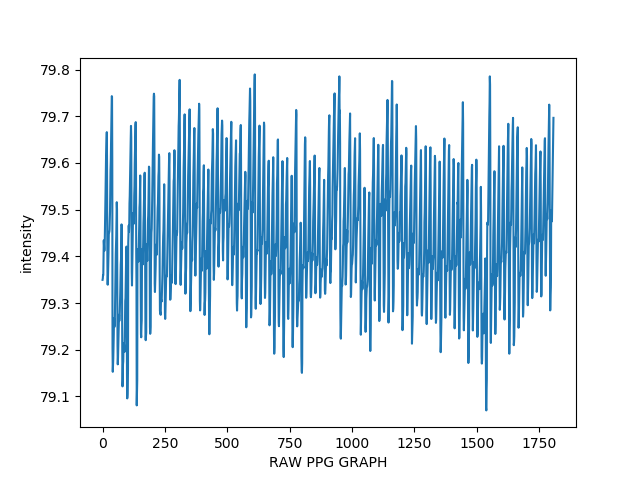

In [86]:
%matplotlib notebook
# Plot The PPG Graph
num=0
import mpld3
mpld3.enable_notebook()

plt.plot(signal)
plt.xlabel('RAW PPG GRAPH')
plt.ylabel('intensity')
plt.show()

In [12]:
%matplotlib notebook
g_signal=gaussian_filter(signal,sigma=0.5,cval=0.5, truncate=4.0)

# plt.figure(figsize=(10,8))
# plt.xlabel('Gausian+RAW PPG GRAPH')
# plt.plot(g_signal)

In [87]:
%matplotlib notebook
#correcting baseline
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

asx = g_signal.flatten()
print(asx.shape)
Corrected_base = asx-baseline_als(asx, 10000, 0.05)
# plt.figure(figsize=(10,8))
# plt.xlabel('Corrected Baseline PPG GRAPH')
# plt.plot(Corrected_base)

(1546,)


In [88]:
%matplotlib notebook
g_base_signal=gaussian_filter(Corrected_base,sigma=0.5,cval=0.5, truncate=5.0)

#plt.figure(figsize=(10,8))
# plt.xlabel('Gausian+RAW PPG GRAPH')
# plt.plot(g_base_signal)

In [89]:
%matplotlib notebook
from scipy.signal import savgol_filter
sig_filter = savgol_filter(Corrected_base, 5, polyorder = 2,deriv=0)
# Plot second derivative
# plt.figure(figsize=(10,8))
# with plt.style.context(('ggplot')):
#     plt.plot(sig_filter)
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.show()

In [90]:
phone='oneplus6t'
name='Sajid Ahmed'

<IPython.core.display.Javascript object>


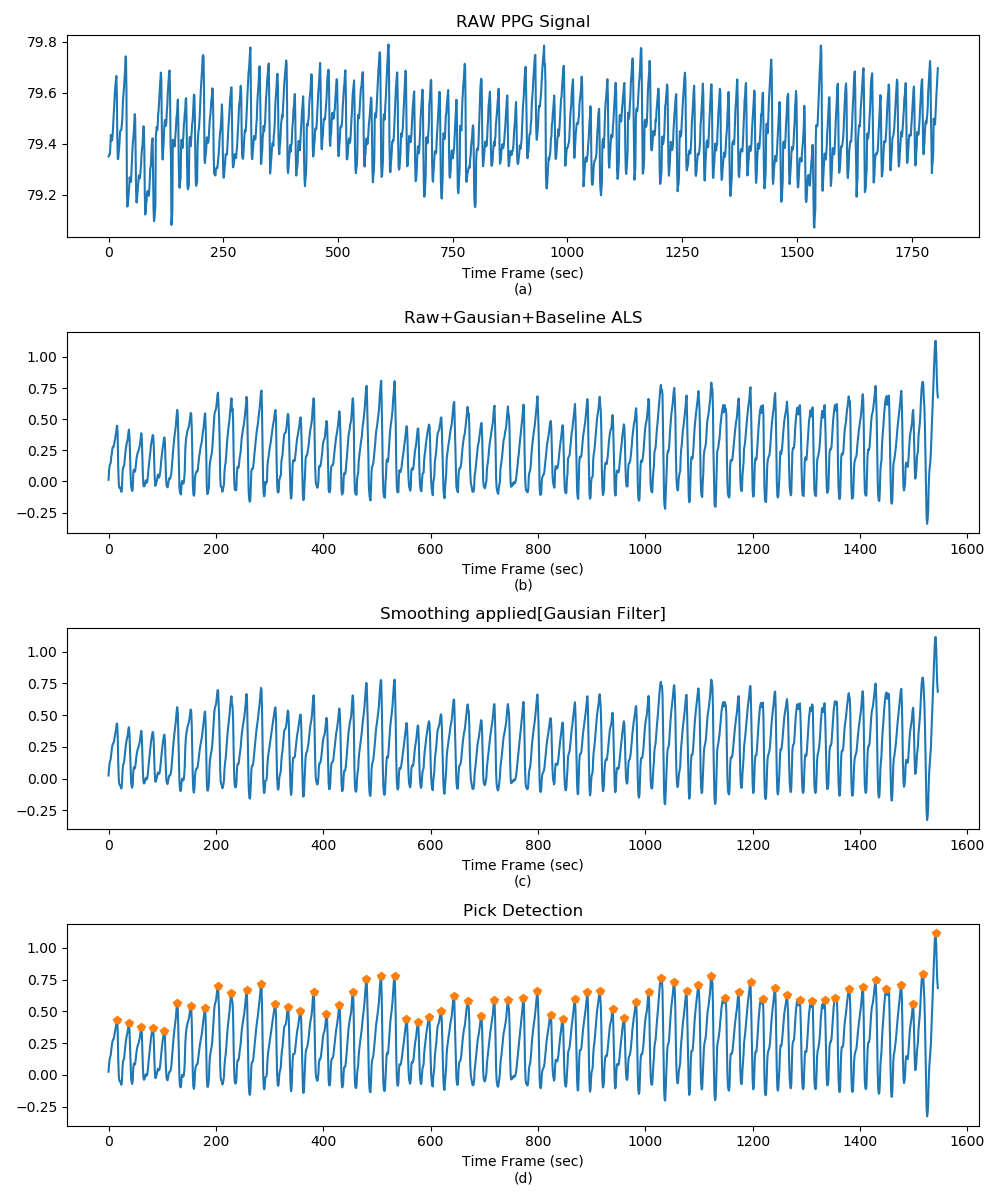

In [92]:
%matplotlib notebook
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib import gridspec

fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(4, 1) 

ax0 = plt.subplot(gs[0])
ax0.set_title('RAW PPG Signal')
ax0.plot(signal)
ax0.set_xlabel('Time Frame (sec)\n(a)')
ax0.set_ylabel('')

ax1 = plt.subplot(gs[1])
ax1.set_title('Raw+Gausian+Baseline ALS')
ax1.plot(Corrected_base)
ax1.set_xlabel('Time Frame (sec)\n(b)')
ax1.set_ylabel('')

smoothed_signal = gaussian_filter1d(Corrected_base, 0.55)
ax2 = plt.subplot(gs[2])
ax2.set_title('Smoothing applied[Gausian Filter]')
ax2.plot(smoothed_signal)
ax2.set_xlabel('Time Frame (sec)\n(c)')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

peaks2, _ = find_peaks(smoothed_signal, distance=18)
s_height2 = peak_prominences(smoothed_signal, peaks2)[0]
contour_heights2 = smoothed_signal[peaks2] - s_height2

ax3 = plt.subplot(gs[3])
ax3.set_title('Pick Detection')
ax3.plot(smoothed_signal)
ax3.plot(peaks2, smoothed_signal[peaks2], "p")
ax3.set_xlabel('Time Frame (sec)\n(d)')
ax3.set_ylabel('')
plt.tight_layout()
plt.show()

fig.savefig('figures/'+str(phone)+'_'+str(name)+'_.png', bbox_inches='tight')

In [95]:
signal = np.asarray(signal)
max_vt = np.amax(signal)
min_vt = np.amin(signal)

min_vc = np.amin(Corrected_base)
max_vc = np.amax(Corrected_base)

<IPython.core.display.Javascript object>


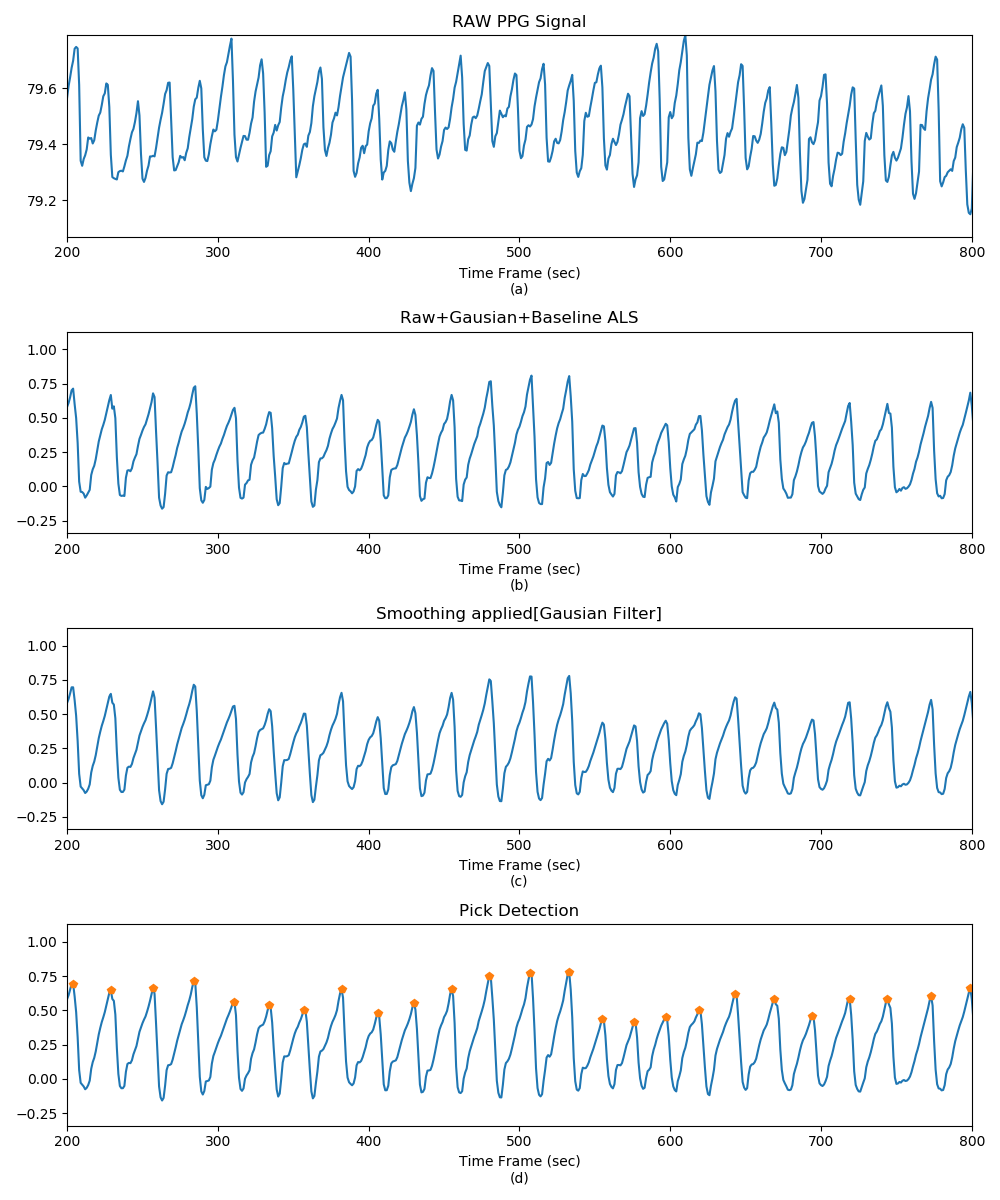

In [96]:
%matplotlib notebook
from scipy.ndimage.filters import gaussian_filter1d
from matplotlib import gridspec

fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(4, 1) 

ax0 = plt.subplot(gs[0])
ax0.set_title('RAW PPG Signal')
ax0.plot(signal)
ax0.set_xlabel('Time Frame (sec)\n(a)')
ax0.set_ylabel('')
plt.axis([200,800,min_vt,max_vt])

ax1 = plt.subplot(gs[1])
ax1.set_title('Raw+Gausian+Baseline ALS')
ax1.plot(Corrected_base)
ax1.set_xlabel('Time Frame (sec)\n(b)')
ax1.set_ylabel('')
plt.axis([200,800,min_vc,max_vc])

smoothed_signal = gaussian_filter1d(Corrected_base, 0.55)
ax2 = plt.subplot(gs[2]) 
ax2.set_title('Smoothing applied[Gausian Filter]')
ax2.plot(smoothed_signal)
ax2.set_xlabel('Time Frame (sec)\n(c)')
ax2.set_ylabel('')
plt.tight_layout()
plt.axis([200,800,min_vc,max_vc])
plt.show()

ax3 = plt.subplot(gs[3])
ax3.set_title('Pick Detection')
ax3.plot(smoothed_signal)
ax3.plot(peaks2, smoothed_signal[peaks2], "p")
ax3.set_xlabel('Time Frame (sec)\n(d)')
ax3.set_ylabel('')
plt.tight_layout()
plt.axis([200,800,min_vc,max_vc])
plt.show()

fig.savefig('figures/'+str(phone)+'_'+str(name)+'zoom_.png', bbox_inches='tight')